In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.1.0
# tf.compat.v1.disable_v2_behavior()
# !pip install --upgrade gensim --user
# !pip install -q pyyaml h5py  # Required to save models in HDF5 format
# !pip install np_utils
# !pip install --upgrade --user keras
# import nltk
# nltk.download('punkt')
# !pip install bert-tensorflow
# # !pip install bert-for-tf2
# !pip install sentencepiece
# !pip install unidecode
# %tensorflow_version 1.x
# import tensorflow as tf
# print(tf.__version__)
# tf.test.gpu_device_name()

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
import json
import os
import glob
import pickle
#from os import path
# import malaya

In [5]:
df_allnews_unpickled = pd.read_pickle("./malaya_fake_news_preprocessed_dataframe.pkl")        #Load FakeNews Dataset from your path
df_allnews_unpickled

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0
...,...,...,...,...,...,...,...
37587,katie holmes tidak mengandung anak jamie foxx ...,"[katie, holmes, tidak, mengandung, anak, jamie...",katie holmes tidak mengandung anak jamie foxx ...,336,0,0,1
37588,donald trump menegaskan bahawa serangan siber ...,"[donald, trump, menegaskan, bahawa, serangan, ...",donald trump menegaskan bahawa serangan siber ...,248,1,1,0
37589,ia bukan cerita pertama yang bermula dengan pe...,"[ia, bukan, cerita, pertama, yang, bermula, de...",ia bukan cerita pertama yang bermula dengan pe...,663,1,1,0
37590,presiden donald trump mengumumkan bahawa dia t...,"[presiden, donald, trump, mengumumkan, bahawa,...",presiden donald trump mengumumkan bahawa dia t...,100,1,1,0


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import tensorflow as tf
from __future__ import division, print_function
import gensim
from gensim import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Bidirectional, LSTM, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
# from keras.layers.recurrent import LSTM
# from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
import json
import re
import sentencepiece as spm
import time

In [ ]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling
import numpy as np
import json
import tensorflow_hub as hub
import itertools
from unidecode import unidecode
from tqdm import tqdm
from collections import namedtuple

In [ ]:
from bertclassify import prepro_utils

sp_model = spm.SentencePieceProcessor()
sp_model.Load('./bert-small/sp10m.cased.v4.model')

with open('./bert-small/sp10m.cased.v4.vocab') as fopen:
    v = fopen.read().split('\n')[:-1]
v = [i.split('\t') for i in v]
v = {i[0]: i[1] for i in v}

class Tokenizer:
    def __init__(self, v):
        self.vocab = v
        pass
    
    def tokenize(self, string):
        return prepro_utils.encode_pieces(sp_model, string, return_unicode=False, sample=False)
    
    def convert_tokens_to_ids(self, tokens):
        return [sp_model.PieceToId(piece) for piece in tokens]
    
    def convert_ids_to_tokens(self, ids):
        return [sp_model.IdToPiece(i) for i in ids]
    
tokenizer = Tokenizer(v)

In [ ]:
BERT_INIT_CHKPNT = './bert-small/model.ckpt'
BERT_CONFIG = './bert-small/bert_config.json'

In [ ]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)

In [ ]:
MAX_SEQ_LENGTH = 128
tokenizer.tokenize(df_allnews_unpickled.iloc[0,2])

In [ ]:
from tqdm import tqdm

input_ids, input_masks, segment_ids = [], [], []

for text in tqdm(df_allnews_unpickled["rejoined"].tolist()):
    tokens_a = tokenizer.tokenize(text)
    if len(tokens_a) > MAX_SEQ_LENGTH - 2:
        tokens_a = tokens_a[:(MAX_SEQ_LENGTH - 2)]
    tokens = ["<cls>"] + tokens_a + ["<sep>"]
    segment_id = [0] * len(tokens)
    input_id = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_id)
    padding = [0] * (MAX_SEQ_LENGTH - len(input_id))
    input_id += padding
    input_mask += padding
    segment_id += padding
    
    input_ids.append(input_id)
    input_masks.append(input_mask)
    segment_ids.append(segment_id)

100%|██████████| 37592/37592 [00:49<00:00, 757.41it/s]


In [ ]:
idx_temp = 142

print (len(input_ids))
print (len(input_masks))
print (len(segment_ids))

print (input_ids[idx_temp])
print (input_masks[idx_temp])
print (segment_ids[idx_temp])

input_ids = np.asarray(input_ids, dtype=np.int32)
input_masks = np.asarray(input_masks, dtype=np.int32)
segment_ids = np.asarray(segment_ids, dtype=np.int32)

37592
37592
37592
[3, 11870, 15062, 104, 17147, 68, 1161, 17, 11926, 5008, 684, 4197, 142, 29728, 314, 22, 4544, 22, 16019, 12984, 20, 6292, 6353, 14629, 5186, 5026, 25, 17, 69, 2976, 17, 2606, 15642, 257, 12220, 225, 8039, 1430, 2988, 171, 2994, 5703, 9405, 225, 320, 745, 17, 17598, 6197, 588, 494, 17, 17598, 11461, 588, 494, 631, 2031, 189, 3066, 2698, 6054, 21, 8187, 68, 4214, 861, 2906, 4007, 120, 6284, 176, 29, 7084, 20, 10560, 780, 1960, 13354, 1444, 20, 625, 120, 1061, 29, 10365, 35442, 68, 5025, 1613, 24238, 9819, 4007, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
label_names = ['real', 'fake']
labels_list = df_allnews_unpickled["label"].values
# labels_list = df_allnews_unpickled[label_names].values
# labels_list = sub_df_allnews[label_names].values
# print (labels_list[42])
# print (sequences_all[42])
# # Zip back the news and labels into a temporary list
all_inputs_zipped = list(zip(input_ids, input_masks, segment_ids))
# all_newsnlabels = list(zip(input_ids, input_masks, segment_ids, labels_list))
# print (all_newsnlabels[42][0])
# print (all_newsnlabels[42][1])

In [ ]:
# print (df_allnews_unpickled.iloc[42])
# print (len(all_newsnlabels[42][0]))
# print (len(all_newsnlabels[42][1]))
# print (len(all_newsnlabels[42][2]))
# print (all_newsnlabels[42][3])

print (df_allnews_unpickled.iloc[42])
print (len(all_inputs_zipped[42][0]))
print (len(all_inputs_zipped[42][1]))
print (len(all_inputs_zipped[42][2]))
print (labels_list[42])

news        pulau staten , n y , pernahkah ia tertanya tan...
tokens      [pulau, staten, n, y, pernahkah, ia, tertanya,...
rejoined    pulau staten n y pernahkah ia tertanya tanya s...
label                                                       1
real                                                        1
fake                                                        0
Name: 42, dtype: object
128
128
128
1


In [ ]:
num_epoch = 2
batch_size = 64
warmup_proportion = 0.1
num_train_steps = int(len(df_allnews_unpickled["rejoined"].tolist()) / batch_size * num_epoch)
num_warmup_steps = int(num_train_steps * warmup_proportion)

Define FT-BERT Architecture

In [ ]:
class FTBERT_Model:
    def __init__(
        self,
        dimension_output,
        learning_rate = 2e-5,
    ):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.input_masks = tf.placeholder(tf.int32, [None, None])
        self.segment_ids = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        # self.X = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,
        #                                name="input_word_ids")
        # self.masks = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,
        #                               name="input_mask")
        # self.segments = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,
        #                             name="segment_ids")
        # self.X = Input(shape = (None, ), dtype = "int32")
        # self.masks = Input(shape = (None, ), dtype = "int32")
        # self.segments = Input(shape = (None, ), dtype = "int32")

        
        bert_model = modeling.BertModel(
            config=bert_config,
            is_training=True,
            input_ids=self.X,
            input_mask=self.input_masks,
            token_type_ids=self.segment_ids,
            use_one_hot_embeddings=False)
        
        ####################################
        bert_output = bert_model.get_pooled_output()
        # bert_output = bert_model.get_sequence_output()
        ####################################
        
        ####################################
        # conv_output = Conv1D(filters=10, kernel_size=3, strides=1, activation="relu")(bert_output)
        # pool_output = Lambda(lambda x: K.max(x, axis=1), output_shape=(100, ))(conv_output)
        
        # convs = []
        # filter_sizes = [3,4,5]
        # for filter_size in filter_sizes:
        #     l_conv = Conv1D(filters=100, kernel_size=filter_size, activation='relu')(bert_output)
        #     l_pool = GlobalMaxPooling1D()(l_conv)
        #     convs.append(l_pool)
        # l_merge = concatenate(convs, axis=1)

        # l_pool = GlobalAveragePooling1D()(bert_output)
        # lstm_output = LSTM(512, go_backwards=True, dropout=0.2)(bert_output)

        # l_pool = GlobalAveragePooling1D()(bert_output)
        # l_dense1 = Dense(6, activation='relu')(l_pool)
        # l_dense2 = Dense(6, activation='relu')(l_dense1)
        # l_dense3 = Dense(6, activation='relu')(l_dense2)
        # l_dense4 = Dense(6, activation='relu')(l_dense3)
        # l_dense5 = Dense(6, activation='relu')(l_dense4)
        ####################################

        ####################################
        x3 = Dropout(0.5)(bert_output)
        # x3 = Dropout(0.5)(pool_output)  
        # x3 = Dropout(0.5)(l_merge)  
        # x3 = Dropout(0.5)(lstm_output)  
        # x3 = Dropout(0.5)(l_dense5)  
        ####################################  
        
        self.logits = Dense(len(list(label_names)), activation='softmax')(x3)


        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        
        self.optimizer = optimization.create_optimizer(self.cost, learning_rate, 
                                                       num_train_steps, num_warmup_steps, False)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
dimension_output = 2
learning_rate = 2e-5

tf.reset_default_graph()
sess = tf.InteractiveSession()
# tf.initialize_all_variables().run()
model = FTBERT_Model(
    dimension_output,
    learning_rate
)

# model = FTBERT(len(list(label_names)))

sess.run(tf.global_variables_initializer())
var_lists = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'bert')
saver = tf.train.Saver(var_list = var_lists)
saver.restore(sess, BERT_INIT_CHKPNT)


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./bert-small/model.ckpt


In [ ]:
# # Only run once before starting a new InteractiveSession() from above Code Section
sess.close()

In [ ]:
saver = tf.train.Saver()

In [ ]:
# # model.save_weights('./bertclassify/bert_model.h5')
save_path = saver.save(sess, "./bertclassify/bert_training_10fold/bert_model.ckpt")

In [ ]:
# # model.load_weights('./bertclassify/bert_model.h5')
saver.restore(sess, "./bertclassify/bert_training_10fold/bert_model.ckpt")

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt


In [ ]:
# weights = []
# for layer in model.layers:
#     weights.append(layer.get_weights()) # list of numpy arrays

# print ((weights[6][0]))

vars = tf.trainable_variables()
print(vars)

var = [v for v in tf.trainable_variables() if v.name == "dense_19/kernel:0"][0]
# print(var)
print("Weight matrix: \n{0}".format(sess.run(var))) 

K-fold Cross Validation stars here

In [ ]:
num_folds = 10
# num_epochs = 3    
# batch_size = 50
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)

In [ ]:
# data_train, data_test = train_test_split(all_newsnlabels, test_size=0.10, random_state=42)
# inputs = [input_ids, input_masks, segment_ids]
inputs = np.asarray(all_inputs_zipped)
targets = labels_list
print (len(inputs))
print (len(targets))

arr_id = np.asarray(df_allnews_unpickled.index)
print (len(arr_id))

# x_train = np.asarray([row[0] for row in data_train])
# y_train = np.asarray([row[1] for row in data_train])
# x_test = np.asarray([row[0] for row in data_test])
# y_test = np.asarray([row[1] for row in data_test])
# print (x_train[42])
# print (y_train[42])
# print (inputs[39505])
# print (targets[39505])

37592
37592
37592


In [ ]:
fold_no = 1
results_history = []
#[0] list_train_acc
#[1] list_val_acc
#[2] list_train_loss
#[3] list_val_loss

acc_per_fold = []
loss_per_fold = []

# # Lists for metrics result
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# # Lists for plotting Precision-Recall Curve
all_arr_precision = []
all_arr_recall = []
all_thresholds = []
all_ave_precision = []

# # Lists for Confusion Matrices
all_cf_matrices = []

# # Lists for Noise Data
all_wrong = []

for train, test in kfold.split(inputs, targets):
  saver.restore(sess, "./bertclassify/bert_training_10fold/bert_model.ckpt")     #Load the same initial weights for all splits
  x_train = np.asarray(inputs[train])
  y_train = np.asarray(targets[train])
  x_test = np.asarray(inputs[test])
  # y_test = np.asarray(targets[test])
  
  temp_arr_id = np.asarray(arr_id[test])

  # data_train_val = list(zip(x_train, y_train))      #Rezip to manually split train and validation
  # data_train_val = np.column_stack(x_train,y_train)   #Stack columns to manually split train and validation
  data_train_val = []
  for m in range(len(x_train)):
    temp_list = x_train[m].tolist()
    temp_list.append(y_train[m].tolist())
    data_train_val.append(temp_list)

  data_train, data_val = train_test_split(data_train_val, test_size=0.10, random_state=42)
  
  x_train_ids = np.asarray([row[0] for row in data_train_val])
  x_train_masks = np.asarray([row[1] for row in data_train_val])
  x_train_segments = np.asarray([row[2] for row in data_train_val])
  y_train = np.asarray([row[3] for row in data_train_val])

  # x_train_ids = np.asarray([row[0] for row in data_train])
  # x_train_masks = np.asarray([row[1] for row in data_train])
  # x_train_segments = np.asarray([row[2] for row in data_train])
  # y_train = np.asarray([row[3] for row in data_train])

  x_val_ids = np.asarray([row[0] for row in data_val])
  x_val_masks = np.asarray([row[1] for row in data_val])
  x_val_segments = np.asarray([row[2] for row in data_val])
  y_val = np.asarray([row[3] for row in data_val])

  x_test_ids = np.asarray([row[0] for row in x_test.tolist()])
  x_test_masks = np.asarray([row[1] for row in x_test.tolist()])
  x_test_segments = np.asarray([row[2] for row in x_test.tolist()])
  y_test = np.asarray(targets[test])


  # # CHECKING FOR ALL TRAIN/VALIDATE/TEST ITEMS starts
  # print (len(x_train_ids))
  # print (len(x_train_masks))
  # print (len(x_train_segments))
  # print (len(y_train))
  # print()

  # print (len(x_val_ids))
  # print (len(x_val_masks))
  # print (len(x_val_segments))
  # print (len(y_val))
  # print()

  # print (len(x_test_ids))
  # print (len(x_test_masks))
  # print (len(x_test_segments))
  # print (len(y_test))
  # print()

  # id_tmp = 19

  # print ((x_train_ids[id_tmp]))
  # print ((x_train_masks[id_tmp]))
  # print ((x_train_segments[id_tmp]))
  # print ((y_train[id_tmp]))
  # print()

  # print ((x_val_ids[id_tmp]))
  # print ((x_val_masks[id_tmp]))
  # print ((x_val_segments[id_tmp]))
  # print ((y_val[id_tmp]))
  # print()

  # print ((x_test_ids[id_tmp]))
  # print ((x_test_masks[id_tmp]))
  # print ((x_test_segments[id_tmp]))
  # print ((y_test[id_tmp]))
  # print()
  # # CHECKING FOR ALL TRAIN/VALIDATE/TEST ITEMS ends
  
  
  # # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for Fold {fold_no} ...')
  
  
  list_train_loss = []
  list_train_acc = []
  list_val_loss = []
  list_val_acc = []

  #########################################
  # # manual work for model.fit() starts here
  # TRAIN AND VALIDATE
  for m in range(num_epoch):
      lasttime = time.time()

      train_acc, train_loss, val_acc, val_loss = 0, 0, 0, 0
      pbar_train = tqdm(range(0, len(x_train_ids), batch_size), desc = 'Training Minibatch Loop', position=0, leave=True)
      for i in pbar_train:
          index = min(i + batch_size, len(x_train_ids))
          batch_x = x_train_ids[i: index]
          batch_masks = x_train_masks[i: index]
          batch_segment = x_train_segments[i: index]
          batch_y = y_train[i: index]
          acc, cost, _ = sess.run(
              [model.accuracy, model.cost, model.optimizer],
              feed_dict = {
                  model.Y: batch_y,
                  model.X: batch_x,
                  model.segment_ids: batch_segment,
                  model.input_masks: batch_masks
              },
          )
          assert not np.isnan(cost)
          train_loss += cost
          train_acc += acc
          pbar_train.set_postfix(cost = cost, accuracy = acc)
      
      pbar_val = tqdm(range(0, len(x_test_ids), batch_size), desc = 'Validation Minibatch Loop', position=0, leave=True)      #val/test
      for i in pbar_val:
          index = min(i + batch_size, len(x_test_ids))        #val/test 
          batch_x = x_test_ids[i: index]                      #val/test
          batch_masks = x_test_masks[i: index]                #val/test
          batch_segment = x_test_segments[i: index]           #val/test
          batch_y = y_test[i: index]                          #val/test
          acc, cost = sess.run(
              [model.accuracy, model.cost],
              feed_dict = {
                  model.Y: batch_y,
                  model.X: batch_x,
                  model.segment_ids: batch_segment,
                  model.input_masks: batch_masks
              },
          )
          val_loss += cost
          val_acc += acc
          pbar_val.set_postfix(cost = cost, accuracy = acc)

      
      train_loss /= len(pbar_train)
      train_acc /= len(pbar_train)
      val_loss /= len(pbar_val) 
      val_acc /= len(pbar_val)
      
      list_train_loss.append(train_loss)
      list_train_acc.append(train_acc)
      list_val_loss.append(val_loss)
      list_val_acc.append(val_acc)
          
      print('Time Taken:', time.time() - lasttime)
      print('Epoch: %d, train_loss: %f, train_acc: %f, val_loss: %f, val_acc: %f\n'
          % (m+1, train_loss, train_acc, val_loss, val_acc)
      )

  # results_history.append(hist)
  # results_history.append(hist.history)
  templist = list(zip(list_train_acc, list_val_acc, list_train_loss, list_val_loss))
  results_history.append(templist)
  templist = []
  # # manual work for model.fit() ends here
  #########################################
    
  

  #########################################
  # # manual work for model.evaluate() starts here
  # EVALUATE MODEL ON TEST SET
  test_acc, test_loss = 0, 0

  pbar_test = tqdm(range(0, len(x_test_ids), batch_size), desc = 'Testing Minibatch Loop', position=0, leave=True)
  for i in pbar_test:
      index = min(i + batch_size, len(x_test_ids))
      batch_x = x_test_ids[i: index]
      batch_masks = x_test_masks[i: index]
      batch_segment = x_test_segments[i: index]
      batch_y = y_test[i: index]
      acc, cost = sess.run([model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x,
                model.segment_ids: batch_segment,
                model.input_masks: batch_masks
            },
        )
      test_loss += cost
      test_acc += acc
      pbar_test.set_postfix(cost = cost, accuracy = acc)                    
      
  test_loss /= len(pbar_test) 
  test_acc /= len(pbar_test)
  print('Time Taken:', time.time() - lasttime)
  print('test_loss: %f, test_acc: %f\n'
      % (test_loss, test_acc)
  )
  
  print(f'Score for Fold {fold_no}: Loss of {test_loss}; Accuracy of {test_acc*100}%')
  acc_per_fold.append(test_acc * 100)
  loss_per_fold.append(test_loss)
  # # manual work for model.evaluate() ends here
  #########################################



  #########################################
  # # manual work for model.predict() starts here
  # METRICS REQUIREMENTS CALCULATION STARTS HERE
  yhat_probs_all = []       # yhat_probs = non-argmax/min predict_Y
  y_probs = []              # y_probs = yhat_probs[:, 0]  #Predicted Probabilities
  yhat_classes = []         # yhat_classes = predict_Y              #Predicted Classes
  y_test_conv = []          # y_test_conv => y_test = real_Y        #Actual Classes

  pbar_test_metrics = tqdm(range(0, len(x_test_ids), batch_size), desc = 'Testing for Metrics Minibatch Loop', position=0, leave=True)
  for i in pbar_test_metrics:
      index = min(i + batch_size, len(x_test_ids))
      batch_x = x_test_ids[i: index]
      batch_masks = x_test_masks[i: index]
      batch_segment = x_test_segments[i: index]
      batch_y = y_test[i: index]
      yhat_probs = sess.run(model.logits,
              feed_dict = {
                  model.Y: batch_y,
                  model.X: batch_x,
                  model.segment_ids: batch_segment,
                  model.input_masks: batch_masks
              },
            )
      # yhat_probs_all.append(yhat_probs)
      # y_probs = np.append(y_probs, (np.max(yhat_probs, axis=1)))
      y_probs = np.append(y_probs, (np.asarray(yhat_probs[:, 0])))     #Consider only positive-predicted class for Precision Recall Curve
      yhat_classes = np.append(yhat_classes, (np.argmax(yhat_probs, axis=-1)))            #formerly predict_Y
      y_test_conv = np.append(y_test_conv, batch_y)                                       #formerly real_Y
  
  # # manual work for model.predict() ends here
  #########################################
  
  for m in range(len(yhat_classes)):
    if (yhat_classes[m] != y_test_conv[m]):
      all_wrong.append(temp_arr_id[m])   


  ## Metrics calculation
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test_conv, yhat_classes)
  all_accuracy.append(accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test_conv, yhat_classes)
  all_precision.append(precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test_conv, yhat_classes)
  all_recall.append(recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test_conv, yhat_classes)
  all_f1.append(f1)

  ## Precision-Curve calculation
  arr_precision, arr_recall, thresholds = precision_recall_curve(y_test_conv, y_probs)
  thresholds = np.concatenate([thresholds,[thresholds[thresholds.size-1]]])
  all_arr_precision.append(arr_precision)
  all_arr_recall.append(arr_recall)
  all_thresholds.append(thresholds)

  ave_precision = average_precision_score(y_test_conv, y_probs)
  all_ave_precision.append(ave_precision)

  ## Confusion Matrix calculation
  cf_matrix = confusion_matrix(y_test_conv, yhat_classes)
  all_cf_matrices.append(cf_matrix)

  # Increase fold number
  fold_no = fold_no + 1
####################################

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



# # Create Dataframe to save all train/val history result
df_history = pd.DataFrame(results_history)
df_history.to_pickle("./bertclassify/BERTTrainHistoryDict_10fold.pkl")
# df_history

# # Create Dataframe to save all Metrics Result
df_allmetrics_10fold = pd.DataFrame(acc_per_fold)
df_allmetrics_10fold.columns = ['acc_per_fold']
df_allmetrics_10fold['loss_per_fold'] = loss_per_fold

df_allmetrics_10fold['all_accuracy'] = all_accuracy
df_allmetrics_10fold['all_precision'] = all_precision
df_allmetrics_10fold['all_recall'] = all_recall
df_allmetrics_10fold['all_f1'] = all_f1

df_allmetrics_10fold['all_arr_precision'] = all_arr_precision
df_allmetrics_10fold['all_arr_recall'] = all_arr_recall
df_allmetrics_10fold['all_thresholds'] = all_thresholds
df_allmetrics_10fold['all_ave_precision'] = all_ave_precision

df_allmetrics_10fold['all_cf_matrices'] = all_cf_matrices

df_allmetrics_10fold.to_pickle("./bertclassify/bert_all_metrics_10fold.pkl")
# df_allmetrics_10fold


# # Create Dataframe to save all wrongly predicted index
df_indices = pd.DataFrame(all_wrong)
df_indices.columns = ['indices']
df_indices.to_pickle("./bertclassify/bert_indices_wrong.pkl")

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 1 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.6938729286194
Epoch: 1, train_loss: 0.463205, train_acc: 0.841245, val_loss: 0.403713, val_acc: 0.904396



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 435.65886187553406
Epoch: 2, train_loss: 0.391862, train_acc: 0.918561, val_loss: 0.394547, val_acc: 0.916225



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 452.6684718132019
test_loss: 0.394228, test_acc: 0.915696

Score for Fold 1: Loss of 0.3942277234489635; Accuracy of 91.5695621805676%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:17<00:00,  3.45it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 2 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 435.6978163719177
Epoch: 1, train_loss: 0.467966, train_acc: 0.836295, val_loss: 0.416180, val_acc: 0.893008



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 435.6128942966461
Epoch: 2, train_loss: 0.396214, train_acc: 0.914012, val_loss: 0.403557, val_acc: 0.905720



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 452.6235017776489
test_loss: 0.403461, test_acc: 0.906427

Score for Fold 2: Loss of 0.40346115271923905; Accuracy of 90.64265540090658%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.49it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 3 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.003121137619
Epoch: 1, train_loss: 0.465702, train_acc: 0.838528, val_loss: 0.418097, val_acc: 0.891808



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 435.9013509750366
Epoch: 2, train_loss: 0.390327, train_acc: 0.919922, val_loss: 0.410033, val_acc: 0.897826



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 452.9489233493805
test_loss: 0.408600, test_acc: 0.900210

Score for Fold 3: Loss of 0.40860006415237815; Accuracy of 90.02096107450582%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 4 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.3715875148773
Epoch: 1, train_loss: 0.465235, train_acc: 0.840067, val_loss: 0.404173, val_acc: 0.904520



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 436.52965474128723
Epoch: 2, train_loss: 0.393745, train_acc: 0.916466, val_loss: 0.395760, val_acc: 0.912296



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 453.57691526412964
test_loss: 0.396468, test_acc: 0.911428

Score for Fold 4: Loss of 0.3964683650913885; Accuracy of 91.14282818163856%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.47it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 5 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.76409244537354
Epoch: 1, train_loss: 0.462256, train_acc: 0.841502, val_loss: 0.408381, val_acc: 0.901894



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 436.7942838668823
Epoch: 2, train_loss: 0.390225, train_acc: 0.920289, val_loss: 0.399697, val_acc: 0.910104



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 453.8731870651245
test_loss: 0.401126, test_acc: 0.908419

Score for Fold 5: Loss of 0.40112622208514453; Accuracy of 90.841935650777%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.47it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 6 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.95480608940125
Epoch: 1, train_loss: 0.463011, train_acc: 0.842164, val_loss: 0.411395, val_acc: 0.899607



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 436.834335565567
Epoch: 2, train_loss: 0.391411, train_acc: 0.918609, val_loss: 0.401086, val_acc: 0.907816



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 453.91711950302124
test_loss: 0.401947, test_acc: 0.909141

Score for Fold 6: Loss of 0.40194681589886294; Accuracy of 90.91405969555095%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 7 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.91290760040283
Epoch: 1, train_loss: 0.463363, train_acc: 0.839873, val_loss: 0.408272, val_acc: 0.900474



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 436.92918133735657
Epoch: 2, train_loss: 0.393840, train_acc: 0.917247, val_loss: 0.394744, val_acc: 0.915136



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 453.97672939300537
test_loss: 0.394675, test_acc: 0.916894

Score for Fold 7: Loss of 0.39467498104451065; Accuracy of 91.68939327789565%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.47it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 8 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.92898082733154
Epoch: 1, train_loss: 0.466179, train_acc: 0.837882, val_loss: 0.413865, val_acc: 0.896479



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 436.62623834609985
Epoch: 2, train_loss: 0.391455, train_acc: 0.918993, val_loss: 0.400873, val_acc: 0.910611



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 453.7255074977875
test_loss: 0.399664, test_acc: 0.912488

Score for Fold 8: Loss of 0.39966440907979417; Accuracy of 91.24876038502838%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 9 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 436.76094794273376
Epoch: 1, train_loss: 0.464383, train_acc: 0.840215, val_loss: 0.419522, val_acc: 0.884511



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 437.0155107975006
Epoch: 2, train_loss: 0.392395, train_acc: 0.918133, val_loss: 0.405518, val_acc: 0.904543



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 454.070387840271
test_loss: 0.405116, test_acc: 0.904999

Score for Fold 9: Loss of 0.4051162706593336; Accuracy of 90.49990985353115%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]

INFO:tensorflow:Restoring parameters from ./bertclassify/bert_training_10fold/bert_model.ckpt



Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for Fold 10 ...


Training Minibatch Loop:   0%|          | 0/529 [00:00<?, ?it/s]

Time Taken: 437.09222626686096
Epoch: 1, train_loss: 0.461168, train_acc: 0.843076, val_loss: 0.407774, val_acc: 0.902520



Testing Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 437.10631132125854
Epoch: 2, train_loss: 0.390532, train_acc: 0.920214, val_loss: 0.393645, val_acc: 0.916556



Testing for Metrics Minibatch Loop:   0%|          | 0/59 [00:00<?, ?it/s]

Time Taken: 454.2158191204071
test_loss: 0.392854, test_acc: 0.917181

Score for Fold 10: Loss of 0.39285371313660833; Accuracy of 91.7181301925142%


Testing for Metrics Minibatch Loop: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.3942277234489635 - Accuracy: 91.5695621805676%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.40346115271923905 - Accuracy: 90.64265540090658%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.40860006415237815 - Accuracy: 90.02096107450582%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.3964683650913885 - Accuracy: 91.14282818163856%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.40112622208514453 - Accuracy: 90.841935650777%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.40194681589886294 - Accuracy: 90.91405969555095%
-----------------------------------------------------------------------

In [ ]:
#TODO: Determine history for each fold

# history_dict = hist.history
# history_dict = results_history[0]
# # history_dict = hist
# history_dict.keys()

Plot Loss and Accuracy for each Fold between Training and Validation for each epoch.


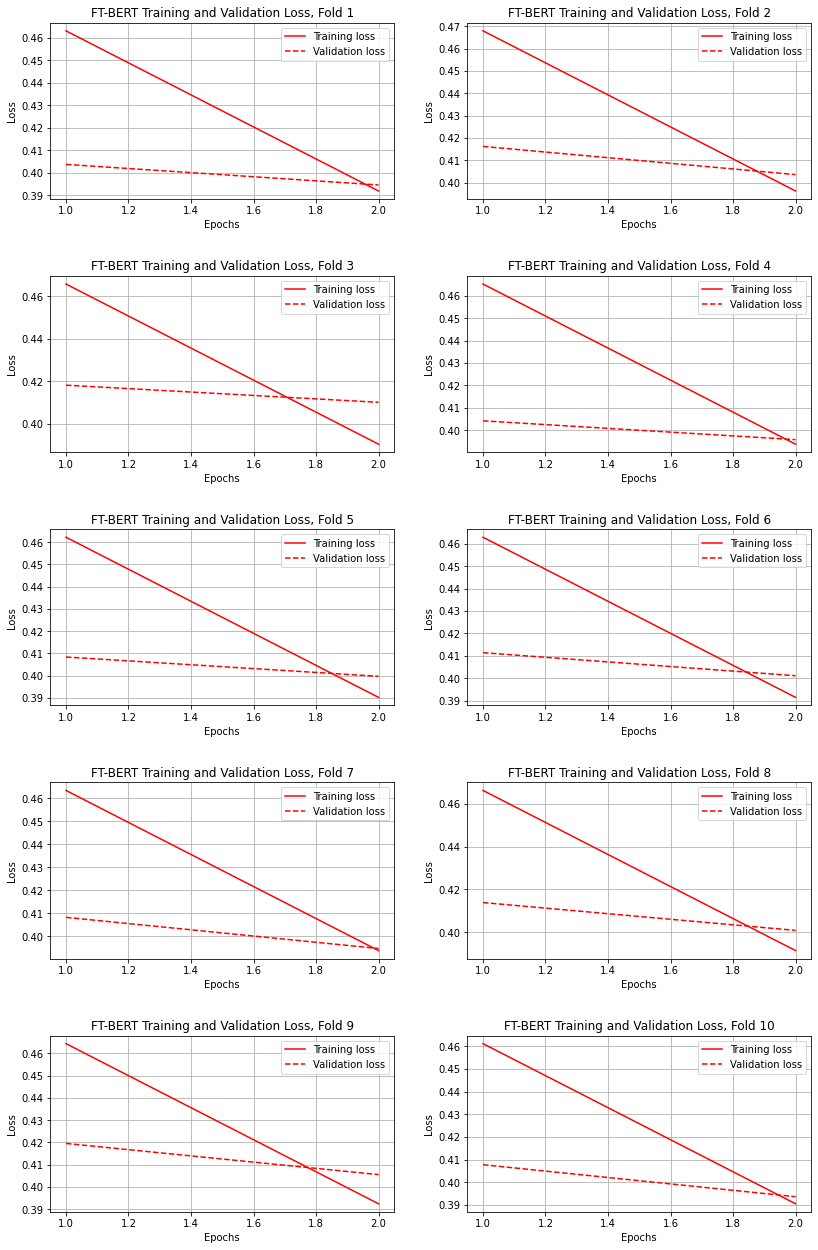

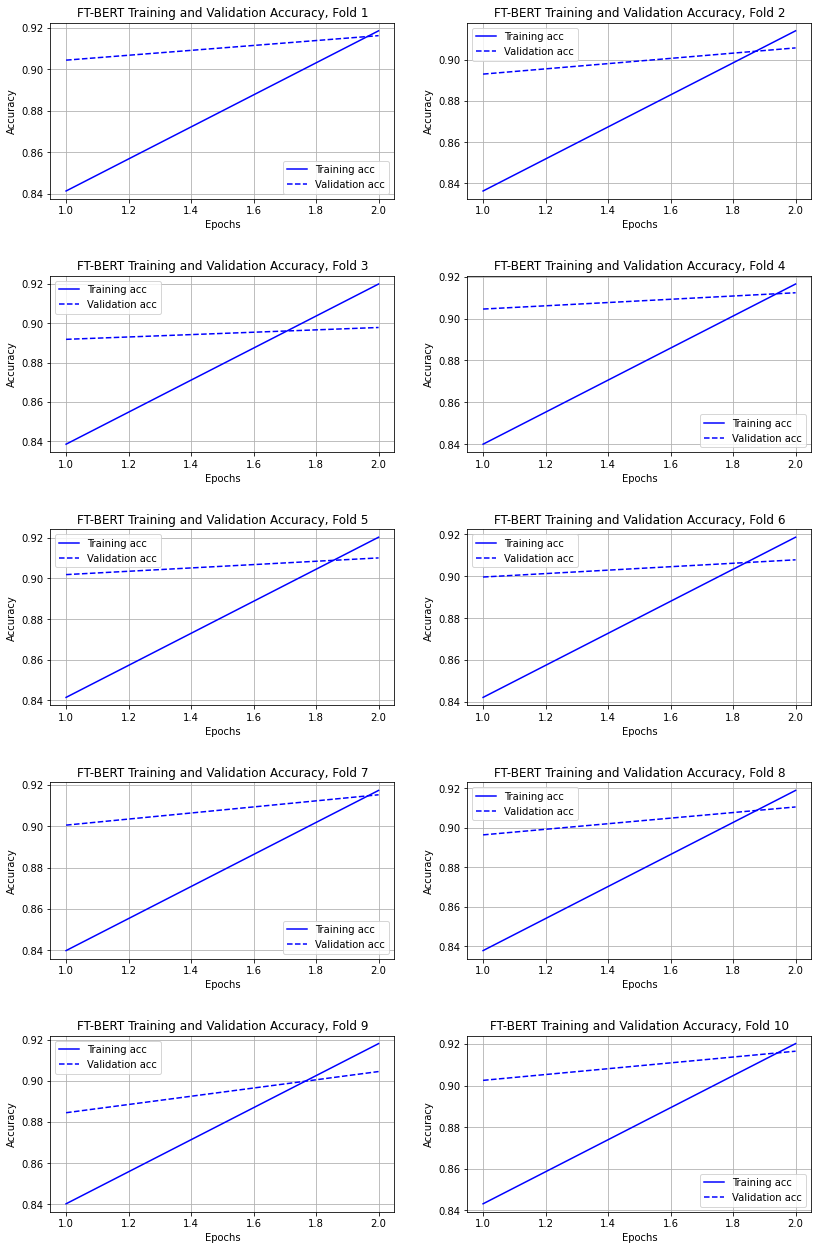

In [ ]:
import matplotlib.pyplot as plt

acc = []
val_acc = []
loss = []
val_loss = []

for i in range(len(results_history)):
  tmp_acc, tmp_val_acc, tmp_loss, tmp_val_loss = [], [], [], []
  for j in range(len(results_history[i])):
    tmp_acc.append(np.asarray(results_history[i][j][0]))
    tmp_val_acc.append(np.asarray(results_history[i][j][1]))
    tmp_loss.append(np.asarray(results_history[i][j][2]))
    tmp_val_loss.append(np.asarray(results_history[i][j][3]))
  acc.append(tmp_acc)
  val_acc.append(tmp_val_acc)
  loss.append(tmp_loss)
  val_loss.append(tmp_val_loss)

  #[0] list_train_acc
  #[1] list_val_acc
  #[2] list_train_loss
  #[3] list_val_loss


# # Loss Plot
epochs = range(1, len(acc[0]) + 1)
fig_row = -(-(len(acc)) // 2)
fig_col = 2
plt.rcParams['figure.figsize'] = [12, 18]
for i in range(len(loss)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, loss[i], 'r', label='Training loss')
  plt.plot(epochs, val_loss[i], 'r--', label='Validation loss')
  plt.title('FT-BERT Training and Validation Loss, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # plt.minorticks_on()
plt.tight_layout(pad=3.0)
plt.savefig("./bertclassify/bert_loss_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


# # Accuracy Plot
plt.clf()   # clear figure
for i in range(len(acc)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, acc[i], 'b', label='Training acc')
  plt.plot(epochs, val_acc[i], 'b--', label='Validation acc')
  plt.title('FT-BERT Training and Validation Accuracy, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig("./bertclassify/bert_accuracy_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()

Calculate Model Metrics
<br> Precision, Recall, Accuracy, F1-Score

In [ ]:
idx_best = 0
best_acc = 0

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Metrics Score per fold')
for i in range(0, len(all_accuracy)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1}')
  print('Accuracy: %f' % all_accuracy[i])
  print('Precision: %f' % all_precision[i])
  print('Recall: %f' % all_recall[i])
  print('F1 score: %f' % all_f1[i])
  if (all_accuracy[i] >= best_acc):
    idx_best = i
    best_acc = all_accuracy[i]
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Accuracy: {np.mean(np.asarray(all_accuracy))}')
print(f'> Average Precision: {np.mean(np.asarray(all_precision))}')
print(f'> Average Recall: {np.mean(np.asarray(all_recall))}')
print(f'> Average F1 Score: {np.mean(np.asarray(all_f1))}')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Metrics Score per fold
------------------------------------------------------------------------
> Fold 1
Accuracy: 0.915957
Precision: 0.921719
Recall: 0.955449
F1 score: 0.938281
------------------------------------------------------------------------
> Fold 2
Accuracy: 0.905319
Precision: 0.905291
Recall: 0.955870
F1 score: 0.929894
------------------------------------------------------------------------
> Fold 3
Accuracy: 0.900505
Precision: 0.910930
Recall: 0.941697
F1 score: 0.926058
------------------------------------------------------------------------
> Fold 4
Accuracy: 0.910615
Precision: 0.915152
Recall: 0.955696
F1 score: 0.934985
------------------------------------------------------------------------
> Fold 5
Accuracy: 0.910082
Precision: 0.906215
Recall: 0.965887
F1 score: 0.935100
------------------------------------------------------------------------
> Fold 6
Accuracy: 0.909284
Precision: 0.92161

Plot Precision-Recall Curve

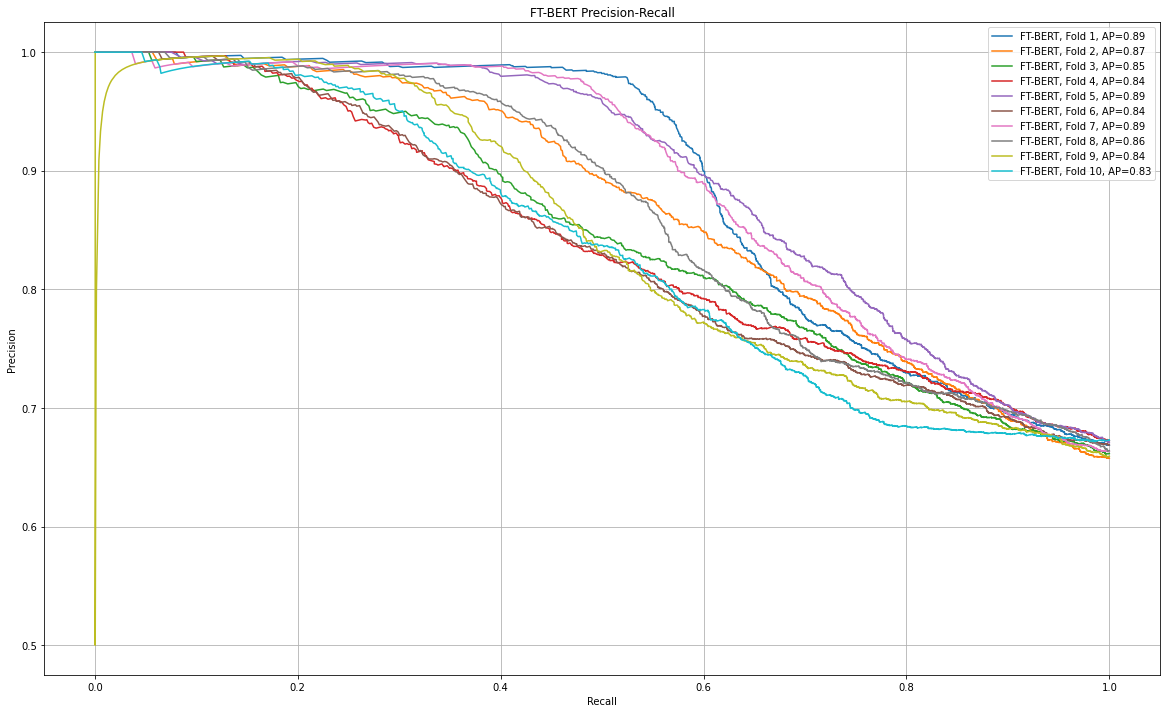

In [ ]:
import matplotlib.cm as cm

colors = cm.tab10(np.linspace(0, 1, len(all_arr_recall)))


plt.clf()   # clear figure
plt.rcParams['figure.figsize'] = [20, 12]

for i in range(len(all_arr_recall)):
  plt.plot(all_arr_recall[i], all_arr_precision[i], color=colors[i], label='FT-BERT, Fold {}, AP={:0.2f}'.format(i+1, all_ave_precision[i]))
  # plt.plot(np.linspace(0, 1, thresholds[i].size), thresholds[i], linestyle='--', label='Threshold')
plt.title('FT-BERT Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.minorticks_on()
plt.savefig("./bertclassify/bert_10fold_precision_recall.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


Draw Confusion Matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

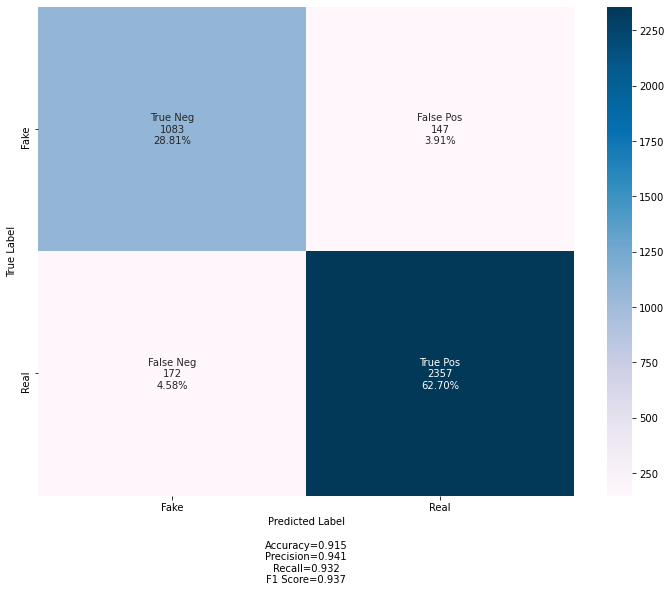

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 9]
for j in range(len(all_cf_matrices)):
  cf_matrix_best = all_cf_matrices[j]

  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  all_accuracy[j],all_precision[j],all_recall[j],all_f1[j])

  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix_best.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_best.flatten()/np.sum(cf_matrix_best)]

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
            
  labels = np.asarray(labels).reshape(2,2)
  categories = ['Fake', 'Real']
  # cmap = sns.dark_palette("red")
  # cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
  # cmap = sns.color_palette("GnBu_d")

  plt.clf() 
  plt.figure()
  svm = sns.heatmap(cf_matrix_best, annot=labels, fmt='', cmap='PuBu',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True Label')
  plt.xlabel('Predicted Label' + stats_text)

  # figure = svm.get_figure()    
  # figure.savefig('./bertclassify/bert_conf_matrix.png', dpi=150)

  plt.savefig("./bertclassify/cfpr/bert_best_10fold_conf_matrix_fold{}.png".format(j+1), format='png', dpi=150, bbox_inches='tight')

In [ ]:
for m in range(len(all_arr_precision)):
  df_prerec = pd.DataFrame(all_arr_precision[m])
  df_prerec.columns = ['precision']
  df_prerec['recall'] = all_arr_recall[m]
  df_prerec['threshold'] = all_thresholds[m]
  df_prerec
  df_prerec.to_pickle("./bertclassify/cfpr/bert_best_10fold_precison_recall_curve_fold{}.pkl".format(m+1))

In [ ]:
!jupyter nbconvert --to html ./bertclassify/bert_classification_malay_10fold.ipynb

[NbConvertApp] Converting notebook ./bertclassify/bert_classification_malay_10fold.ipynb to html
[NbConvertApp] Writing 963516 bytes to ./bertclassify/bert_classification_malay_10fold.html
